# Prediction on Test Set

In [1]:
# Clone GitHub Repository
!git clone https://github.com/sabin74/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform.git

Cloning into 'Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 384 (delta 94), reused 46 (delta 10), pack-reused 216 (from 1)
Receiving objects: 100% (384/384), 42.34 MiB | 18.73 MiB/s, done.
Resolving deltas: 100% (206/206), done.
Updating files: 100% (64/64), done.
Filtering content: 100% (26/26), 367.45 MiB | 42.61 MiB/s, done.


In [2]:
!pip install -q catboost
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 4.5 MB/s eta 0:00:00


## Load Test Data

In [3]:
# Environment Setup - Import Libraries
import os
import gc
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from category_encoders import TargetEncoder

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Set Project Root
os.chdir("/content/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform")
print("Current Directory: ", os.getcwd())

Current Directory:  /content/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform


In [5]:
# Load Feature-Engineered Data
DATA_DIR = Path("data/features")

train = pd.read_parquet(DATA_DIR / "train_features.parquet")
test  = pd.read_parquet(DATA_DIR / "test_features.parquet")

train = train.sort_values(["store_nbr", "family", "date"]).reset_index(drop=True)
test  = test.sort_values(["store_nbr", "family", "date"]).reset_index(drop=True)

print("Train shape:", train.shape)
print("Test shape :", test.shape)

Train shape: (3054348, 62)
Test shape : (28512, 38)


In [13]:
# Load All Model and Ensemble Bundle
bundle = joblib.load("models/ensemble-stacking/final_ensemble_model.pkl")

print("Loaded Ensemble Components:")
for k in bundle:
    print(" -", k)

Loaded Ensemble Components:
 - rf_model
 - xgb_model
 - lgb_model
 - cat_model
 - target_encoder
 - meta_model
 - bias
 - zero_threshold


In [6]:
# Memory Optimization
def reduce_mem_usage(df):
    for col in df.columns:
        if df[col].dtype == "float64":
            df[col] = df[col].astype("float32")
        elif df[col].dtype == "int64":
            df[col] = df[col].astype("int32")
    return df

train = reduce_mem_usage(train)
test  = reduce_mem_usage(test)
gc.collect()

0

In [7]:
# Define Lag / Rolls
LAGS  = [1, 7, 14, 28]
ROLLS = [7, 14, 28]
MAX_LAG = max(LAGS)

In [8]:
# Build Initial History Store
history_df = train[
    train["date"] >= (train["date"].max() - pd.Timedelta(days=MAX_LAG + 30))
][["store_nbr", "family", "date", "sales", "onpromotion", "dcoilwtico"]].copy()

history_df = history_df.sort_values(
    ["store_nbr", "family", "date"]
).reset_index(drop=True)

In [9]:
# Define Feature Generator
def generate_sales_features(history, current, lags, rolls):
    for lag in lags:
        current[f"sales_lag_{lag}"] = (
            history.groupby(["store_nbr","family"])["sales"]
            .shift(lag)
            .reindex(current.index)
        )
    for r in rolls:
        roll = (
            history.groupby(["store_nbr","family"])["sales"]
            .rolling(r)
            .agg(["mean","std"])
            .reset_index(level=[0,1], drop=True)
        )
        current[f"sales_roll_mean_{r}"] = roll["mean"].reindex(current.index)
        current[f"sales_roll_std_{r}"]  = roll["std"].reindex(current.index)
    return current


def generate_promo_features(history, current, lags, rolls):
    for lag in lags:
        current[f"promo_lag_{lag}"] = (
            history.groupby(["store_nbr","family"])["onpromotion"]
            .shift(lag)
            .reindex(current.index)
        )
    for r in rolls:
        rolling = history.groupby(["store_nbr","family"])["onpromotion"].rolling(r)
        current[f"promo_roll_sum_{r}"] = rolling.sum().reset_index(level=[0,1], drop=True)
        current[f"promo_freq_{r}"] = rolling.mean().reset_index(level=[0,1], drop=True)
    current["promo_flag"] = (current["onpromotion"] > 0).astype(int)
    return current


def generate_oil_features(history, current, lags):
    for lag in lags:
        current[f"oil_lag_{lag}"] = (
            history.groupby("store_nbr")["dcoilwtico"]
            .shift(lag)
            .reindex(current.index)
        )
    return current

In [10]:
# Training Feature List
DROP_COLS = ["id", "date", "sales", "sales_log"]
TRAIN_FEATURES = [c for c in train.columns if c not in DROP_COLS]

In [11]:
# Final Prediction Function
def predict_from_bundle(X_raw, bundle):

    X_te = bundle["target_encoder"].transform(X_raw)

    preds = np.column_stack([
        bundle["rf_model"].predict(X_te),
        bundle["xgb_model"].predict(xgb.DMatrix(X_te)),
        bundle["lgb_model"].predict(X_raw, num_iteration=bundle["lgb_model"].best_iteration),
        bundle["cat_model"].predict(X_raw),
    ])

    y_log = bundle["meta_model"].predict(preds)
    y_log += bundle["bias"]
    y_log = np.where(y_log < bundle["zero_threshold"], 0, y_log)

    return np.expm1(y_log)

In [14]:
# Recursive Test Prediction Loop
test_preds = []
test_dates = sorted(test["date"].unique())

for current_date in test_dates:

    test_day = test[test["date"] == current_date].copy()

    temp_history = pd.concat([history_df, test_day], ignore_index=True)

    test_day = generate_sales_features(temp_history, test_day, LAGS, ROLLS)
    test_day = generate_promo_features(temp_history, test_day, [1,7], ROLLS)
    test_day = generate_oil_features(temp_history, test_day, [7,14,28])

    # Safe filling
    sales_cols = [c for c in test_day if "sales_" in c]
    test_day[sales_cols] = test_day[sales_cols].fillna(0)
    test_day = test_day.ffill().bfill()

    # Predict
    test_day["sales"] = predict_from_bundle(
        test_day[TRAIN_FEATURES], bundle
    )

    # Update history with predictions
    history_df = pd.concat([history_df, test_day], ignore_index=True)

    test_preds.append(test_day)

In [15]:
# Final Test Prediction
test_final = pd.concat(test_preds).reset_index(drop=True)
test_final["sales_pred"] = test_final["sales"]

print("Final Test Shape:", test_final.shape)
test_final[["date","store_nbr","family","sales_pred"]].head()

Final Test Shape: (28512, 62)


,date,store_nbr,family,sales_pred
0,2017-08-16,1,AUTOMOTIVE,0.162462
1,2017-08-16,1,BABY CARE,3.766182
2,2017-08-16,1,BEAUTY,6.733143
3,2017-08-16,1,BEVERAGES,19.898126
4,2017-08-16,1,BOOKS,0.000000


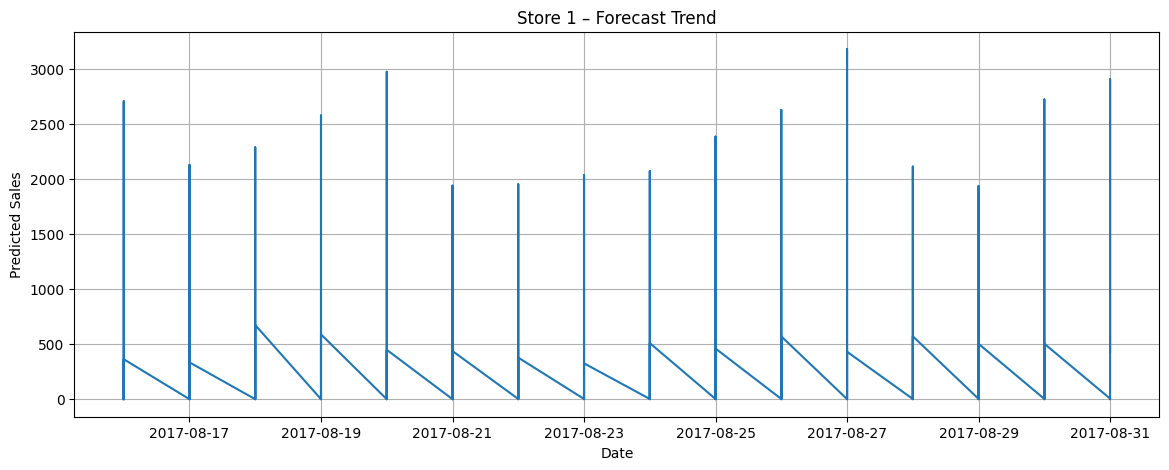

In [19]:
# Plot Test Forecast Trend
daily_forecast = test_final.groupby("date")["sales_pred"].sum().reset_index()

plt.figure(figsize=(14,5))
plt.plot(daily_forecast["date"], daily_forecast["sales_pred"])
plt.title("Test Forecast Trend (Total Sales)")
plt.xlabel("Date")
plt.ylabel("Predicted Sales")
plt.grid(True)
plt.show()